In [588]:
import pandas as pd
import numpy as np
import random
import math
import itertools
import warnings
import pickle
import gc
import sys
import matplotlib.pyplot as plt
from os.path import join, isfile
from collections import Counter, defaultdict
from scipy.special import gamma
from itertools import permutations, combinations, combinations_with_replacement, product
import timeit
import multiprocessing
import tqdm
import time
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{0:0.2f}".format(x)})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### Step 1: Load Beacon, MAF, Reference and other cached variables

In [2]:
mainPath = "../../data"
beacons = join(mainPath, "beacon")
ceuPath = join(beacons, "CEU")

In [3]:
# CEU
beacon = pd.read_csv(join(ceuPath, "Beacon_164.txt"), index_col=0, delim_whitespace=True)
maf = pd.read_csv(join(ceuPath, "MAF.txt"), index_col=0, delim_whitespace=True)
reference = pickle.load(open(join(ceuPath, "reference.pickle"),"rb"))

In [4]:
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int)

maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)

beacon_people = np.arange(65)
other_people = np.arange(99)+65
all_people = np.arange(164)

In [5]:
# Construct beacons and the victim
shuffled = np.random.permutation(all_people)

victim_ind = shuffled[0]
a_cind = shuffled[1:21]
s_cind = shuffled[21:41]

s_ind = shuffled[41:101]

s_beacon = binary[:, np.concatenate([s_ind,np.array([victim_ind])])]
#s_beacon = binary[:, s_ind]

a_control = binary[:, a_cind]
s_control = binary[:, s_cind]

victim = binary[:, victim_ind]

### Step 2: Function definitions

###### SB LRT

In [6]:
# n: Num query
a=1.6483
b=2.2876
error=0.001

def calculate_sb_delta(num_people, response, n):
    DN = gamma(a + b) / (gamma(b) * (2*num_people + a + b)**a)
    DN_1 = gamma(a + b) / (gamma(b) * (2*(num_people-1) + a + b)**a)
    
    B = np.log(DN / (DN_1 * error)) 
    C = np.log((error * DN_1 * (1 - DN)) / (DN*(1-error*DN_1)))
    return n*B + C*response

def sb_lrt(victim, control_people, beacon, A, S, num_query):
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]
    
    response = beacon[A].any(axis=1)*S    
    
    # Delta
    delta = calculate_sb_delta(beacon_size, response, num_query)
    
    # Victim delta
    victim_delta = np.sum(np.dot(delta, victim[A]))
    
    # Control delta
    control_delta = np.dot(delta, control_people[A])

    return victim_delta, control_delta

###### Optimal LRT

In [7]:
# n: Num query

def calculate_optimal_delta(num_people, response, n, maf):
    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    log1 = np.log(DN_i/(error*DN_i_1))
    log2 = np.log((error*DN_i_1 * (1-DN_i)) / (DN_i * (1-error*DN_i_1)))
    return log1 + log2*response

def optimal_lrt(victim, control_people, beacon, A, S, num_query):
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]
    response = beacon[A].any(axis=1)*S    
    maf_i = maf.iloc[A]["maf"].values + 1e-6
    # Delta
    delta = calculate_optimal_delta(beacon_size, response, num_query, maf_i)
    # Victim delta   
    victim_delta = np.sum(np.dot(delta, victim[A]))
    # Control delta
    control_delta = np.dot(delta, control_people[A])
    return victim_delta, control_delta

###### p-value Function

In [8]:
def p_value(victim_delta, control_delta):
    return np.sum(control_delta <= victim_delta) / control_delta.shape[0]

#### Attacker Utility

In [120]:
def utility_sharer(ai, si, p_prevs, p_currents, hps):
    # Gain-Loss=Utility
    s_gain = -1*hps[2]*(1-si) 
    s_loss = hps[0]*-np.log(maf.iloc[ai]["maf"]+1e-6)/abs(np.log(1e-6))
    + hps[1]*np.sum(p_prevs - p_currents)/len(p_prevs)
    + hps[3]*np.sum(p_currents <= 0.05)/len(p_currents)
    return s_gain-s_loss

In [121]:
def utility_attacker(ai, si, p_prev, p_current, num_query, hps):
    # Gain-Loss=Utility
    a_gain = hps[0]*-np.log(maf.iloc[ai]["maf"]+1e-6)/abs(np.log(1e-6)) + hps[1]*(p_prev - p_current)
    a_loss = hps[2]*(1-si) + hps[3]*num_query/100
    return a_gain-a_loss

In [112]:
def U_A_i(ai, si, i, p_prev_victim):
    #ai, si, Ai, Si, p_prev, i
    # Current p-value
    victim_delta, control_delta = optimal_lrt(victim, a_control, s_beacon, ai, si, i)
    p_victim_current = p_value(victim_delta, control_delta)
    # Gain-Loss=Utility
    attacker_utility = utility_attacker(ai[-1], si[-1], p_prev_victim, p_victim_current, i, hps)
    return attacker_utility, p_victim_current

def U_S_i(ai, si, i, p_prev_donors):
    # Current p-value
    p_donors_current = np.zeros(s_beacon.shape[1])
    for j in range(s_beacon.shape[1]):
        victim_delta, control_delta = optimal_lrt(s_beacon[:, j], s_control, s_beacon, ai, si, i)
        p_donors_current[j] = p_value(victim_delta, control_delta)
    sharer_utility =  utility_sharer(ai[-1], si[-1], p_prev_donors, p_donors_current, hps)
    return sharer_utility, p_donors_current

In [333]:
def attacker_utility(a,s,num_query):
    # Attacker Utility
    attacker_utility = np.zeros(num_query)
    # Previous p-value
    p_victim_prev = 1
    for i in range(num_query):
        # Gain-Loss=Utility
        attacker_utility[i], p_victim_prev = U_A_i(a[:i+1], s[:i+1], i+1, p_victim_prev)
    return attacker_utility[-1]

def sharer_utility(a,s,num_query):
    # Sharer Utility
    #sharer_utility = np.zeros(num_query)
    sharer_utility = 0
    # Previous p-value
    p_donors_prev = np.ones(s_beacon.shape[1])
    for i in range(num_query):
        sharer_utility, p_donors_prev =  U_S_i(a[:i+1], s[:i+1], i+1, p_donors_prev)
    return sharer_utility

### Tryouts

In [714]:
num_query = 4
hps = np.random.uniform(low=0.9, high=1, size=(6,))

A = np.random.choice(s_beacon.shape[0], 8)
#all_attacker = np.array(list(combinations(A, num_query)))
all_attacker = np.array(list(permutations(A, num_query)))

S = np.round(np.arange(0.7,1.05,0.1), 2)
#all_sharer = list(combinations_with_replacement(S, num_query))
#all_sharer = list(product(S, repeat=num_query))
all_sharer = [t[::-1] for t in list(combinations_with_replacement(S, num_query))]
print("Will try at most ", len(all_attacker)*len(all_sharer), " iterations")
print(victim[A], A, S)

Will try at most  58800  iterations
[0 0 1 1 0 0 0 0] [ 377886 1434001 1718722  289068 1398701 3959231 1387352 2231441] [0.70 0.80 0.90 1.00]


# MULTIPROCESSOR BABY!!!

In [718]:
utilities = defaultdict(lambda: defaultdict(lambda:(0,0)))
strategies = defaultdict(lambda: defaultdict(lambda:(0,0)))
def func(params):
    a = params[0]
    s = params[1]
    us = np.array([np.array([sharer_utility(np.append(a, ai), np.append(s, si), i) + utilities[a+(ai,)][s+(si,)][1] if ai not in a else -np.inf for si in S]) for ai in A])
    os = np.argmax(us, axis=1)
    bus = us[:, os][:, 0]
    # Find optimum strategy for all possible ai
    ua = np.array([attacker_utility(np.append(a, ai), np.append(s, S[os[t]]), i) + utilities[a+(ai,)][s+(S[os[t]],)][0] if ai not in a else -np.inf for t, ai in enumerate(A)])
    oa = np.argmax(ua)
    bua = ua[oa]
    return a, s, A[oa], S[os[oa]], bua, bus[oa]

for i in range(num_query, 1, -1):
    # Generate all possible past strategy combinations
    #all_attacker = list(combinations(A, i-1))
    all_attacker = list(permutations(A, i-1))
    #all_sharer = list(combinations_with_replacement(S, i-1))
    all_sharer = [t[::-1] for t in list(combinations_with_replacement(S, i-1))]
    # Param grid for multiprocessor pool unit
    paramlist = list(product(all_attacker, all_sharer))
    pool = multiprocessing.Pool()
    res  = pool.map(func,paramlist)
    for r in res:
        strategies[r[0]][r[1]] = (r[2], r[3])
        utilities[r[0]][r[1]] = (r[4], r[5])

In [719]:
# Final step, first query
us = np.array([np.array([sharer_utility(np.array([ai]), np.array([si]), i) + utilities[tuple([ai])][tuple([si])][1] for si in S]) for ai in A])
os = np.argmax(us, axis=1)  
bus = us[:, os][:, 0]

# Find optimum strategy for all possible ai
ua = np.array([attacker_utility(np.array([ai]), np.array([S[os[t]]]), i) + utilities[tuple([ai])][tuple([S[os[t]]])][0] for t, ai in enumerate(A)])
oa = np.argmax(ua)
bua = ua[oa]

# Finally
a_str = [A[oa]]
s_str = [S[os[oa]]]
for i in range(num_query-1):
    a, s = strategies[tuple(a_str)][tuple(s_str)]
    a_str.append(a)
    s_str.append(s)

print(a_str, "\t", s_str)

[377886, 3959231, 1434001, 2231441] 	 [1.0, 1.0, 1.0, 1.0]


In [720]:
attacker_utilities = [0]*num_query
sharer_utilities = [0]*num_query
for i in range(num_query-1, 0, -1):
    #print(a_str[:i+1], "->", s_str[:i+1])
    #print(utilities[tuple(a_str[:i+1])][tuple(s_str[:i+1])])
    #print()
    attacker_utilities[i], sharer_utilities[i] = np.array(utilities[tuple(a_str[:i])][tuple(s_str[:i])]) - np.array(utilities[tuple(a_str[:i+1])][tuple(s_str[:i+1])])
attacker_utilities[0] = bua - np.array(utilities[tuple(a_str[:1])][tuple(s_str[:1])])[0]
sharer_utilities[0] = bus[oa] - np.array(utilities[tuple(a_str[:1])][tuple(s_str[:1])])[1]

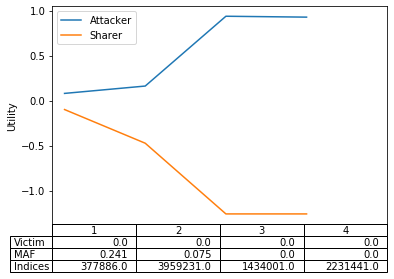

In [721]:
plt.plot(attacker_utilities, label="Attacker")
plt.plot(sharer_utilities, label="Sharer")
#plt.xlabel("Query")
plt.ylabel("Utility")
plt.xticks(np.arange(5), np.arange(5)+1)  # Set text labels
plt.xticks([])
plt.legend()

columns = ('1', '2', '3', '4', '5')
rows = ('Victim', 'MAF', 'Indices')#, '3', '4', '5')
cells = np.vstack([victim[a_str], 
                   maf.iloc[a_str]["maf"].values,
                   a_str])

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cells,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='bottom')

# STASH

In [ ]:
'''
%%time
utilities = defaultdict(lambda: defaultdict(lambda:(0,0)))
strategies = defaultdict(lambda: defaultdict(lambda:(0,0)))

for i in range(num_query, 1, -1):
    # Generate all possible past strategy combinations
    all_attacker = list(combinations(A, i-1))
    all_sharer = list(combinations_with_replacement(S, i-1))
    k = 0
    #for a in all_attacker:
    #    for s in all_sharer:
    for a, s in product(all_attacker, all_sharer):    
        # Find optimum strategy for all possible ai 
        us = np.array([np.array([sharer_utility(np.append(a, ai), np.append(s, si), i) + utilities[a+(ai,)][s+(si,)][1] for si in S]) for ai in A])
        os = np.argmax(us, axis=1)
        bus = us[:, os][:, 0]

        # Find optimum strategy for all possible ai
        ua = np.array([attacker_utility(np.append(a, ai), np.append(s, S[os[t]]), i) + utilities[a+(ai,)][s+(S[os[t]],)][0] for t, ai in enumerate(A)])
        oa = np.argmax(ua)
        bua = ua[oa]

        strategies[a][s] = (A[oa], S[os[oa]])
        utilities[a][s] = (bua, bus[oa])

        k+=1
        if k % 1 == 0:
            print("Completed ", k, " trials for query: ", i)
    break
'''

In [ ]:
'''
utilities = defaultdict(lambda: defaultdict(lambda:(0,0)))
strategies = defaultdict(lambda: defaultdict(lambda:(0,0)))

for i in range(num_query, 1, -1):
    # Generate all possible past strategy combinations
    all_attacker = list(combinations(A, i-1))
    all_sharer = list(combinations_with_replacement(S, i-1))
    k = 0
    for a in all_attacker:
        for s in all_sharer:
            
            start = timeit.default_timer()
            # Find optimum strategy for all possible ai 
            #us = np.array([np.array([sharer_utility(np.append(a, ai), np.append(s, si), i) + utilities[a+(ai,)][s+(si,)][1] for si in S]) for ai in A])
            # ORR
            us = []
            for ai in A:
                temp = []
                for si in S:
                    value = sharer_utility(np.append(a, ai), np.append(s, si), i) + utilities[a+(ai,)][s+(si,)][1]
                    temp.append(value)
                us.append(np.array(temp))
            us = np.array(us)
            
            os = np.argmax(us, axis=1)
            bus = us[:, os][:, 0]
            stop1 = timeit.default_timer()
            
            # Find optimum strategy for all possible ai
            ua = np.array([attacker_utility(np.append(a, ai), np.append(s, S[os[t]]), i) + utilities[a+(ai,)][s+(S[os[t]],)][0] for t, ai in enumerate(A)])
            oa = np.argmax(ua)
            bua = ua[oa]
            stop2 = timeit.default_timer()
            
            strategies[tuple(a)][tuple(s)] = (A[oa], S[os[oa]])
            utilities[tuple(a)][tuple(s)] = (bua, bus[oa])
            #strategies[a][s] = (A[oa], S[os[oa]])
            #utilities[a][s] = (bua, bus[oa])
            stop3 = timeit.default_timer()

            
            k+=1
            if k % 40 == 0:
                print("Completed ", k, " trials for query: ", i)
            stop4 = timeit.default_timer()
            print('Times \nArgmax: ', stop1-start, "\nObjective: ", stop2-stop1, "\nDict: ", stop3-stop2, "\nVerbosity: ", stop4-stop3)  
                
            break
        break
    break
    # Now we have the best strategies for step
#print(utilities, strategies)
'''

In [ ]:
'''
# Attacker Utility
attacker_utility = np.zeros(num_query)

# Previous p-value
p_victim_prev = 1

for i in range(num_query):
    print("QUERY ", i+1)
    print("---------")
    # Current p-value
    victim_delta, control_delta = optimal_lrt(victim, a_control, s_beacon, A[:i+1], S[:i+1], i+1)
    print("Victim delta: ", victim_delta)
    print("Control delta: ", control_delta)
    p_victim_current = p_value(victim_delta, control_delta)
    
    # Gain-Loss=Utility
    attacker_utility[i] = utility_attacker(A[i], S[i], p_victim_prev, p_victim_current, i+1, hps)

    print("U_A(",i+1,"): ", round(attacker_utility[i], 3), "\tP-prev-P-cur: ",p_victim_prev,"-",p_victim_current, "\tMAF: ", maf.iloc[A[i]]["maf"])
    print()

    p_victim_prev = p_victim_current

# Sharer Utility
sharer_utility = np.zeros(num_query)

# Previous p-value
p_donors_prev = np.ones(s_beacon.shape[1])

for i in range(num_query):
    print("QUERY ", i+1)
    print("---------")
    # Current p-value
    p_donors_current = np.zeros(s_beacon.shape[1])

    for j in range(s_beacon.shape[1]):
        victim_delta, control_delta = optimal_lrt(s_beacon[:, j], s_control, s_beacon, A[:i+1], S[:i+1], i+1)
        p_donors_current[j] = p_value(victim_delta, control_delta)
    
    sharer_utility[i] =  utility_sharer(A[i], S[i], p_donors_prev, p_donors_current, hps)
    print("U_S(",i+1,"): ", round(sharer_utility[i], 3), "\tPrev-Cur: ",round(np.sum(p_donors_prev),2),"-",round(np.sum(p_donors_current),2), "\tMAF: ", maf.iloc[A[i]]["maf"])
    print(p_donors_current)
    p_donors_prev = p_donors_current
'''

In [ ]:
'''
#ternary = binary.copy()
#ternary[beacon.values=="NN"] = -1

def lrt_calculate(victim, control_people, beacon, ai, si, num_query):
    victim_delta = 0
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]
    control_delta = np.zeros(control_size)

    for i in range(num_query):
        # Query the beacon
        response = beacon[ai[i]].any(axis=0)*si[i]

        # Victim delta
        victim_delta += calculate_sb_delta(beacon_size, response, 1) * victim[ai[i]]

        # Control delta
        control_delta += calculate_sb_delta(beacon_size, response, 1) * control_people[ai[i]]

    return victim_delta, control_delta
    
    
victim_delta = 0
a_control_delta = np.zeros(60)

for i in range(num_query):
    # Query the beacon
    response = s_beacon[ai[i]].any(axis=0)#*si[i]
    
    # Victim delta
    victim_delta += calculate_sb_delta(60, response, 1) * victim[ai[i]]
    
    # Control delta
    a_control_delta += calculate_sb_delta(60, response, 1) * a_control[ai[i]]
    #print(victim_delta, "-->", a_control_delta)
    
    # p-value of the victim
    p_victim = np.sum(a_control_delta <= victim_delta) / 60
    print(p_victim) 
'''